In [1]:
import datetime
import numpy as np
import pandas as pd

In [2]:
val_seed = 5532
num_darts = [10**2,10**3,10**4,10**5,10**6,10**7,10**8]
val_max = max(num_darts)
print('{:,}'.format(val_max))

100,000,000


In [3]:
print('For reference, Python\'s value of pi = '+str(np.pi))

For reference, Python's value of pi = 3.141592653589793


<img src='./Img_MonteCarloApproach.png'>
From UC Berkeley

# Using Numpy

In [4]:
from operator import add

In [5]:
def get_pi_numpy(val_size,val_max,val_seed=val_seed):
    if(val_size <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        x = np.random.random_sample(size=val_size)
        y = np.random.random_sample(size=val_size)
        x_2 = [i**2 for i in x]
        y_2 = [j**2 for j in y]
        line_len = list(map(add,x_2,y_2))
        less_than_1 = len([1 for i in line_len if i < 1])
        tmp_pi = 4*(less_than_1/val_size)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str('{:,}'.format(val_size))+' ('+str(100*round(val_size/val_max,5))+'% of total); took '+str(total_s)+' secs.')
    return(pd.Series([tmp_pi,total_s]))

In [6]:
%%time
pi_from_numpy = [get_pi_numpy(val_size=x,val_max=val_max) for x in num_darts]
df_pi_from_numpy = pd.DataFrame(pi_from_numpy)
df_pi_from_numpy.columns=['EstPi','Time']
df_pi_from_numpy['Error'] = np.pi-df_pi_from_numpy['EstPi']
df_pi_from_numpy['SampleSize'] = num_darts
df_pi_from_numpy['Src'] = 'Numpy'

Calc. value pi = 3.16; sample size = 100 (0.0% of total); took 0.000199 secs.
Calc. value pi = 3.164; sample size = 1,000 (0.001% of total); took 0.00204 secs.
Calc. value pi = 3.1436; sample size = 10,000 (0.01% of total); took 0.016858 secs.
Calc. value pi = 3.1508; sample size = 100,000 (0.1% of total); took 0.163332 secs.
Calc. value pi = 3.14234; sample size = 1,000,000 (1.0% of total); took 1.341239 secs.
Calc. value pi = 3.14151; sample size = 10,000,000 (10.0% of total); took 15.583332 secs.
Calc. value pi = 3.1416334; sample size = 100,000,000 (100.0% of total); took 169.941635 secs.
CPU times: user 2min 57s, sys: 22.4 s, total: 3min 19s
Wall time: 3min 32s


# Using Pandas

In [7]:
def get_pi_pandas(val_size,val_max,val_seed=val_seed):
    if(val_size <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        df = pd.DataFrame({'x':np.random.random_sample(size=val_size),'y':np.random.random_sample(size=val_size)})
        df['x_2'] = df['x']**2
        df['y_2'] = df['y']**2
        df['line_len'] = df['x_2']+df['y_2']
        df['less_than_1'] = [1 if x < 1 else 0 for x in df['line_len']]
        tmp_pi = 4*(df['less_than_1'].sum()/val_size)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str('{:,}'.format(val_size))+' ('+str(100*round(val_size/val_max,5))+'% of total); took '+str(total_s)+' secs.')
    return(pd.Series([tmp_pi,total_s]))

In [8]:
%%time
pi_from_pandas = [get_pi_pandas(val_size=x,val_max=val_max) for x in num_darts]
df_pi_from_pandas = pd.DataFrame(pi_from_pandas)
df_pi_from_pandas.columns=['EstPi','Time']
df_pi_from_pandas['Error'] = np.pi-df_pi_from_pandas['EstPi']
df_pi_from_pandas['SampleSize'] = num_darts
df_pi_from_pandas['Src'] = 'Pandas'

Calc. value pi = 3.16; sample size = 100 (0.0% of total); took 0.00655 secs.
Calc. value pi = 3.164; sample size = 1,000 (0.001% of total); took 0.004276 secs.
Calc. value pi = 3.1436; sample size = 10,000 (0.01% of total); took 0.013957 secs.
Calc. value pi = 3.1508; sample size = 100,000 (0.1% of total); took 0.040937 secs.
Calc. value pi = 3.14234; sample size = 1,000,000 (1.0% of total); took 0.373937 secs.
Calc. value pi = 3.14151; sample size = 10,000,000 (10.0% of total); took 4.486182 secs.
Calc. value pi = 3.1416334; sample size = 100,000,000 (100.0% of total); took 45.943903 secs.
CPU times: user 45.7 s, sys: 11.1 s, total: 56.9 s
Wall time: 51.3 s


# Using Dask

In [9]:
from dask.distributed import Client, progress
import dask.array as da

In [10]:
client = Client(processes=False, threads_per_worker=2, n_workers=4, memory_limit='3GB')
client

Client Scheduler: inproc://192.168.1.3/36076/1 Dashboard: http://localhost:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.00 GB


In [11]:
def get_pi_dask(val_size,val_max,val_seed=val_seed):
    if(val_size <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        x = da.random.random((val_size, 1), chunks=(val_size/10, 1))
        y = da.random.random((val_size, 1), chunks=(val_size/10, 1))
        x_2 = da.power(x,2)
        y_2 = da.power(y,2)
        line_len = da.add(x_2,y_2)
        line_len.compute()
        less_than_1 = line_len[line_len < 1].compute()
        val_sum = len(less_than_1)
        tmp_pi = 4*(val_sum/val_size)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str('{:,}'.format(val_size))+' ('+str(100*round(val_size/val_max,5))+'% of total); took '+str(total_s)+' secs.')
        del(x,y,x_2,y_2,line_len,less_than_1)
    return(pd.Series([tmp_pi,total_s]))

In [12]:
%%time
pi_from_dask = [get_pi_dask(val_size=x,val_max=val_max) for x in num_darts]
df_pi_from_dask = pd.DataFrame(pi_from_dask)
df_pi_from_dask.columns=['EstPi','Time']
df_pi_from_dask['Error'] = np.pi-df_pi_from_dask['EstPi']
df_pi_from_dask['SampleSize'] = num_darts
df_pi_from_dask['Src'] = 'Dask'

Calc. value pi = 3.4; sample size = 100 (0.0% of total); took 0.246752 secs.
Calc. value pi = 3.048; sample size = 1,000 (0.001% of total); took 0.222948 secs.
Calc. value pi = 3.1128; sample size = 10,000 (0.01% of total); took 0.212762 secs.
Calc. value pi = 3.13528; sample size = 100,000 (0.1% of total); took 0.218996 secs.
Calc. value pi = 3.140548; sample size = 1,000,000 (1.0% of total); took 0.304152 secs.
Calc. value pi = 3.1416568; sample size = 10,000,000 (10.0% of total); took 1.082 secs.


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.81 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 2.54 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 2.65 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Worker is at 54% memory usage. Resuming worker. Process memory: 1.64 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 1.66 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 2.28 GB -- Worker memory limit: 3.00 GB
distributed.worker - WARNING - Memory use is high but worker has no da

Calc. value pi = 3.1417996; sample size = 100,000,000 (100.0% of total); took 18.954296 secs.
CPU times: user 33.3 s, sys: 9.61 s, total: 42.9 s
Wall time: 21.3 s


A snapshot of the Dask dashboard during run time:
<img src='./Img_DaskScreenshot.png'>

# Analysis

In [13]:
%matplotlib inline

In [14]:
df_all = pd.concat([df_pi_from_pandas,df_pi_from_numpy,df_pi_from_dask])
df_all['ErrorMag'] = df_all['Error'].abs()

In [15]:
df_all.sort_values(by=['ErrorMag','Time'])

,EstPi,Time,Error,SampleSize,Src,ErrorMag
6,3.141633,45.943903,-0.000041,100000000,Pandas,0.000041
6,3.141633,169.941635,-0.000041,100000000,Numpy,0.000041
5,3.141657,1.082000,-0.000064,10000000,Dask,0.000064
5,3.141510,4.486182,0.000083,10000000,Pandas,0.000083
5,3.141510,15.583332,0.000083,10000000,Numpy,0.000083
6,3.141800,18.954296,-0.000207,100000000,Dask,0.000207
4,3.142340,0.373937,-0.000747,1000000,Pandas,0.000747
4,3.142340,1.341239,-0.000747,1000000,Numpy,0.000747
4,3.140548,0.304152,0.001045,1000000,Dask,0.001045
2,3.143600,0.013957,-0.002007,10000,Pandas,0.002007


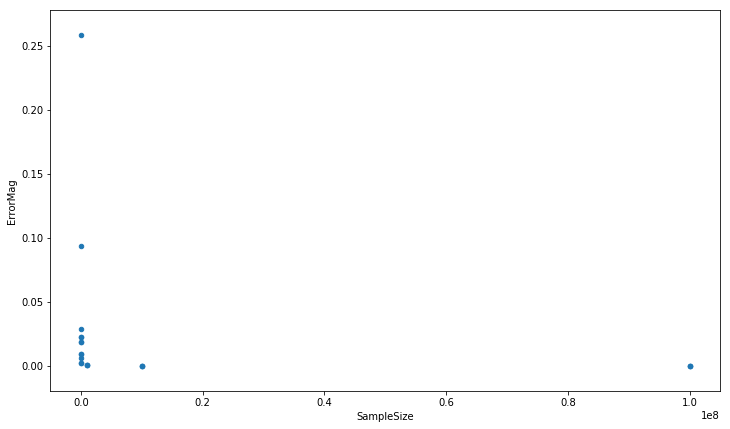

In [16]:
df_all.plot.scatter(x='SampleSize',y='ErrorMag',figsize=(12,7))

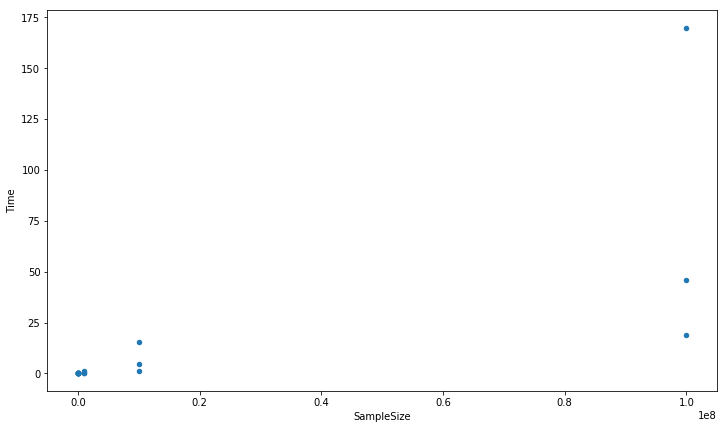

In [17]:
df_all.plot.scatter(x='SampleSize',y='Time',figsize=(12,7))

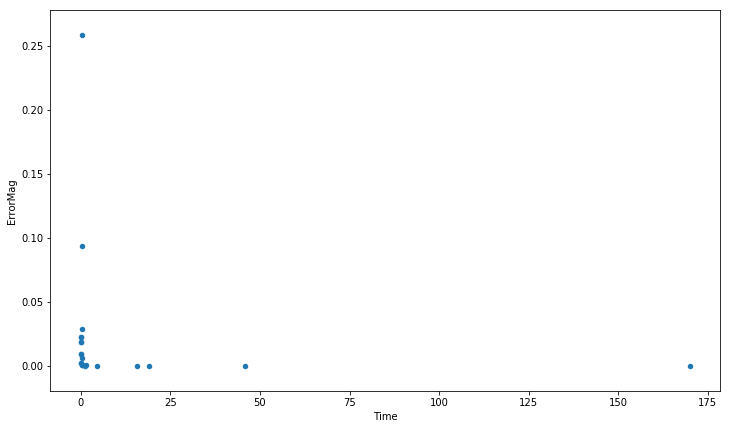

In [18]:
df_all.plot.scatter(x='Time',y='ErrorMag',figsize=(12,7))

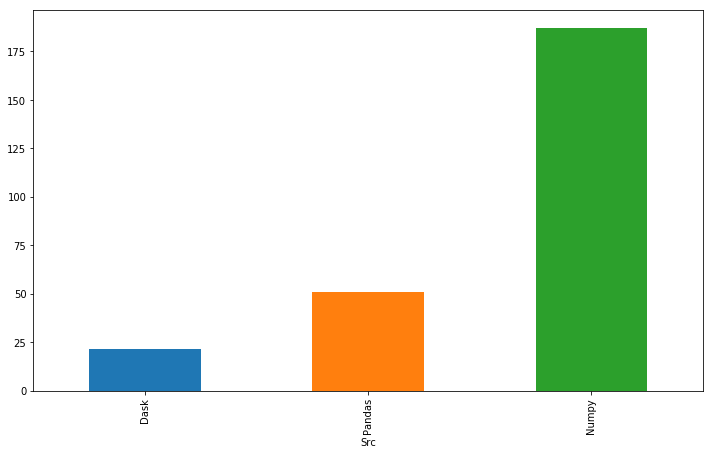

In [19]:
df_all_agg = df_all.pivot_table(index='Src',values='Time',aggfunc=sum).reset_index()
df_all_agg.sort_values(by='Time',inplace=True)
df_all_agg.plot.bar(x='Src',y='Time',figsize=(12,7),legend=False)